# 1. 数据介绍/提出问题

titanica_data.csv 包含了泰坦尼克部分乘客的具体信息，如年龄、性别等

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn
%pylab inline 

/Users/lihongcen/.pyenv/versions/anaconda-2.4.0/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Populating the interactive namespace from numpy and matplotlib


In [2]:
titanic_data = pd.read_csv('titanic_data.csv')
print titanic_data.info()
print titanic_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
None
   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence

In [3]:
titanic_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


## 1.1 基本数据
数据字典
- survival	Survival	0 = No, 1 = Yes
- pclass	Ticket class	1 = 1st, 2 = 2nd, 3 = 3rd
- sex	Sex	
- Age	Age in years	
- sibsp	# of siblings / spouses aboard the Titanic	
- parch	# of parents / children aboard the Titanic	
- ticket	Ticket number	
- fare	Passenger fare	
- cabin	Cabin number	
- embarked	Port of Embarkation

基本情况
- age, cabin, embarked 数据不全（NaN）
- fare 的最高值为512，远大于平均值和75分位不太合理


## 1.2 问题

- 乘客的生存率是多少，性别、仓位、年龄分别的生存率如何
- 统计上能否有明显的父母把生存机会让给自己的孩子的情况出线
- 伴侣/兄妹之间，不同性别生存率是否有明显差异

# 2. 数据整理

检查 PassgenId 的值是否唯一

In [4]:
len(titanic_data['PassengerId'].unique()) == len(titanic_data.index)

True

查看 Pclass\Age\Sex 的分布

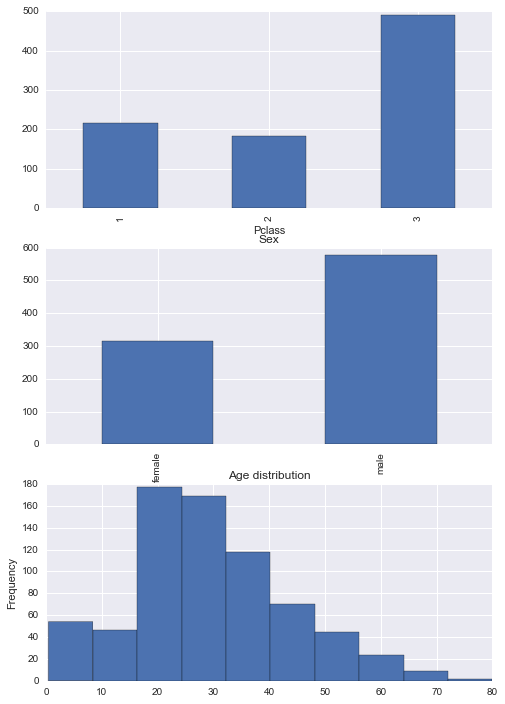

In [5]:
fig, axes = plt.subplots(3, 1)
titanic_data.groupby('Pclass').count()['Survived'].plot.bar(ax=axes[0], figsize=(8,12))
titanic_data.groupby('Sex').count()['Survived'].plot.bar(ax=axes[1], title='Sex')

titanic_data['Age'].plot.hist(title='Age distribution', ax=axes[2])

#离散数据用直方图不太合适

#titanic_data['Pclass'].plot.hist(title='Pclass distribution', ax=axes[0],figsize=(10,10))
#titanic_data['Age'].plot.hist(title='Age distribution', ax=axes[1])
#titanic_data['PassengerId'].plot.hist(title='PassengerId distribution', ax=axes[2])
# figsize与layout size 的区别和设置 

## 2.1 Age 数据处理

title
 Dr          1
 Master      4
 Miss       36
 Mr        119
 Mrs        17
Name: PassengerId, dtype: int64


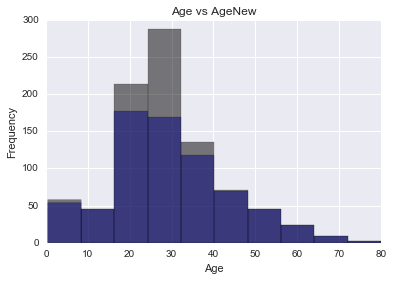

In [6]:
len(titanic_data[pd.isnull(titanic_data['Age'])].index) #177个Age 为NaN情况

name_g = pd.DataFrame(titanic_data['Name'].str.split(',').tolist()) # 将乘客名字变为新的Dataframe
name_g1 = pd.DataFrame(name_g.iloc[:,1].str.split('.',1).tolist()) #分离出称呼 Mrs

titanic_data['title'] = name_g1.iloc[:,0] # 将称呼加入到数据集里
print titanic_data[titanic_data['Age'].isnull()].groupby('title').count()['PassengerId'] #查看年龄为空的title分布
#print titanic_data[~(titanic_data['Age'].isnull())].groupby('title').count()['PassengerId'] #查看年龄不为空的title分布

# AgeNew 将NaN的年纪根据称呼中位数填入
def fill_age(grp):
    grp['AgeNew'] = np.where(grp['Age'].isnull(), grp['Age'].median(),grp['Age'])
    return grp

titanic_data = titanic_data.groupby('title').apply(fill_age)


ax1 = titanic_data['Age'].plot(kind='hist', color='b', alpha=0.5)
ax2 = titanic_data['AgeNew'].plot(kind='hist', color='k', alpha=0.5)
ax2.set(xlabel='Age', ylabel='Frequency', title='Age vs AgeNew')


Mr. 有119个年龄为NaN，按称呼将年龄中位数填入后，30岁人明显增高, 由于只是猜测，分析仍使用'Age'。

## 2.2 Fare 处理

车票价格最高值为512有异常，找出3倍标准差以上的值，发现对应都是对应仓位1 

In [7]:
fare = titanic_data['Fare']
abnormal_fare = fare > (fare.mean()+3*fare.std())
fare[abnormal_fare]

27     263.0000
88     263.0000
118    247.5208
258    512.3292
299    247.5208
311    262.3750
341    263.0000
377    211.5000
380    227.5250
438    263.0000
527    221.7792
557    227.5250
679    512.3292
689    211.3375
700    227.5250
716    227.5250
730    211.3375
737    512.3292
742    262.3750
779    211.3375
Name: Fare, dtype: float64

In [8]:
titanic_data.groupby('Pclass').mean()

,PassengerId,Survived,Age,SibSp,Parch,Fare,AgeNew
Pclass,,,,,,,
1,461.597222,0.629630,38.233441,0.416667,0.356481,84.154687,37.309815
2,445.956522,0.472826,29.877630,0.402174,0.380435,20.662183,29.787120
3,439.154786,0.242363,25.140620,0.615071,0.393075,13.675550,25.757475


In [9]:
titanic_data['Pclass'][abnormal_fare]

27     1
88     1
118    1
258    1
299    1
311    1
341    1
377    1
380    1
438    1
527    1
557    1
679    1
689    1
700    1
716    1
730    1
737    1
742    1
779    1
Name: Pclass, dtype: int64

查询不同等级的金额范围，发现都有票价为0的情况，最高值都显著大于平均值

In [10]:
titanic_data.groupby('Pclass')['Fare'].apply(lambda x: (x.min(), x.max()))

Pclass
1    (0.0, 512.3292)
2        (0.0, 73.5)
3       (0.0, 69.55)
Name: Fare, dtype: object

In [11]:
print (titanic_data['Fare'] == 0).sum()

15


15个乘客购票价格为0 

In [14]:
Pclass_1_fare_0 = (titanic_data['Pclass'] == 1) & (titanic_data['Fare'] == 0)
print titanic_data[Pclass_1_fare_0]
# print titanic_data.iloc[titanic_data['Fare'].argmax()]['Name']

     PassengerId  Survived  Pclass                             Name   Sex  \
263          264         0       1            Harrison, Mr. William  male   
633          634         0       1    Parr, Mr. William Henry Marsh  male   
806          807         0       1           Andrews, Mr. Thomas Jr  male   
815          816         0       1                 Fry, Mr. Richard  male   
822          823         0       1  Reuchlin, Jonkheer. John George  male   

      Age  SibSp  Parch  Ticket  Fare Cabin Embarked      title  AgeNew  
263  40.0      0      0  112059   0.0   B94        S         Mr    40.0  
633   NaN      0      0  112052   0.0   NaN        S         Mr    30.0  
806  39.0      0      0  112050   0.0   A36        S         Mr    39.0  
815   NaN      0      0  112058   0.0  B102        S         Mr    30.0  
822  38.0      0      0   19972   0.0   NaN        S   Jonkheer    38.0  


查看 仓位1，船票费用为0的乘客信息，没有发现规律

Pclass  Embarked
1       C            85
        Q             2
        S           127
2       C            17
        Q             3
        S           164
3       C            66
        Q            72
        S           353
dtype: int64


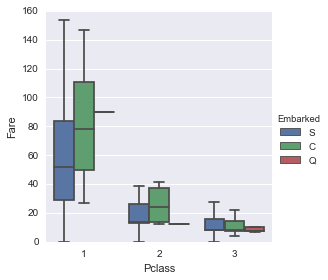

In [13]:
#按仓位和登船点统计船票价格箱体图
# titanic_data.boxplot(column='Fare', by=['Pclass', 'Embarked'],showfliers=False) 
seaborn.factorplot("Pclass", hue="Embarked", y="Fare", data=titanic_data, kind="box",sym = '')
print titanic_data.groupby(['Pclass', 'Embarked'])['Fare'].size()

暂时不知道如何处理，所幸不影响分析

# 数据分析

In [15]:
# 总生存率
total_survived_rate = titanic_data['Survived'].sum() / float(len(titanic_data.index))
print "The whole population survived rate is: ", total_survived_rate

The whole population survived rate is:  0.383838383838


## 3.1 仓位与生存率关系

        survived  total  Survived
Pclass                           
1            136    216  0.629630
2             87    184  0.472826
3            119    491  0.242363


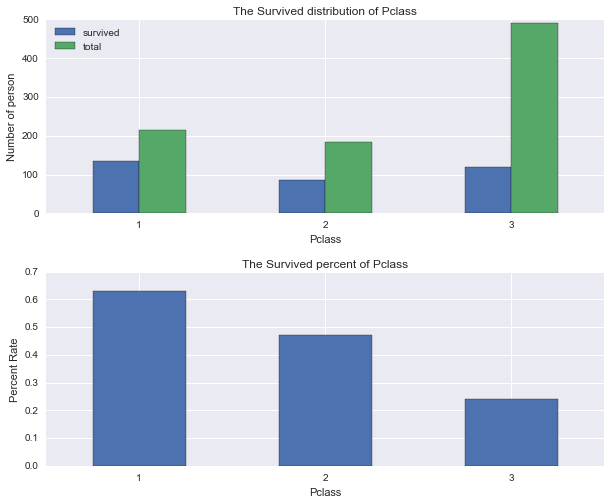

In [16]:
# 定义计算生存率和画图的函数
def survived_by_field(data, field):
    groups = data.groupby(field)
    
    survived_num = groups.sum()['Survived']
    total_num = groups.count()['Survived']
    percent = survived_num / total_num 
    
    table = pd.concat([survived_num, total_num], axis=1)
    table.columns = ['survived', 'total']

    fig, axes = plt.subplots(2, 1)
    table.plot.bar(ax=axes[0], figsize=(10, 8), use_index=True, rot=0, \
                   title=('The Survived distribution of '+field))   
    axes[0].set_ylabel("Number of person")
    

    
    percent.plot(kind='bar', ax=axes[1], use_index=True, rot=0, \
                 title=('The Survived percent of '+field))
    axes[1].set_ylabel("Percent Rate")
    
    plt.subplots_adjust(hspace=0.3) #拉长subplot 间距

    table = pd.concat([table, percent], axis=1 )
    print table


survived_by_field(titanic_data, 'Pclass')


#survived_percent.plot.barh()
#plt.bar(Pclass_group.count()['Survived'].index, Pclass_group.count()['Survived'].values)

头等舱的生存率显著高于平均值为 0.62, 生存率根据仓位依次下降


## 3.2 性别与生存率关系 

In [17]:
survived_by_field(titanic_data_c, 'Sex')

NameError: name 'titanic_data_c' is not defined

女性生存率明显高于男性为0.74

## 3.3 年龄与生存率关系

           survived  total  Survived
Age Group                           
(0, 6]           33     47  0.702128
(6, 18]          37     92  0.402174
(18, 30]         96    270  0.355556
(30, 60]        119    283  0.420495
(60, 90]          5     22  0.227273


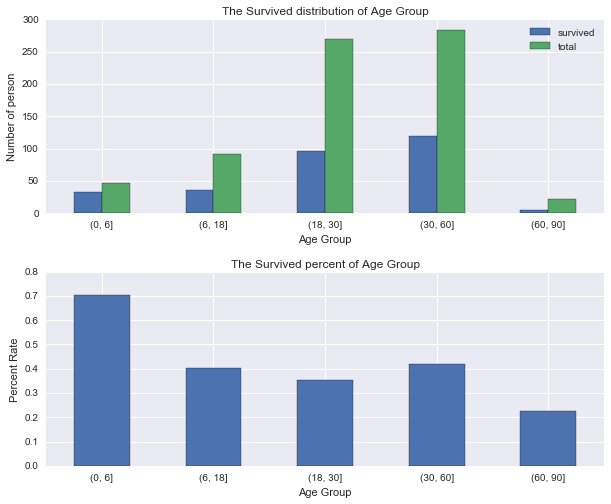

In [246]:
titanic_data['Age Group'] = pd.cut(titanic_data['Age'], bins=[0,6,18,30,60,90])

survived_by_field(titanic_data, 'Age Group')

0-6岁小孩生存率最高0.70，中年30-60岁和少年6-18岁生存率要高于青年18-30岁，60岁以上人群生存率很低。年龄数据有遗失并准确。

              survived  total  Survived
AgeNew Group                           
(0, 6]              35     51  0.686275
(6, 18]             37     92  0.402174
(18, 30]           132    425  0.310588
(30, 60]           133    301  0.441860
(60, 90]             5     22  0.227273


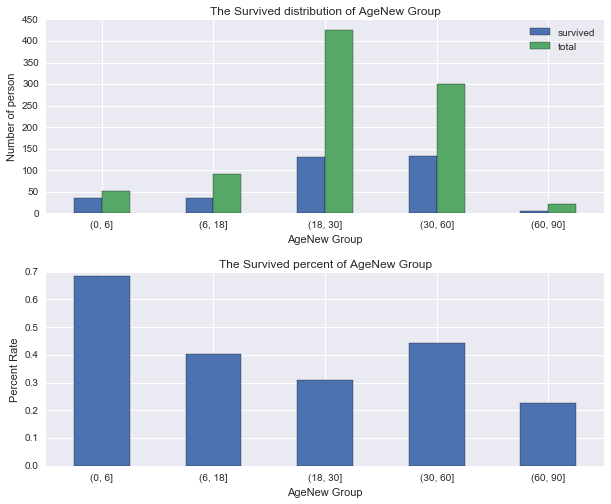

In [244]:
titanic_data['AgeNew Group'] = pd.cut(titanic_data['AgeNew'], bins=[0,6,18,30,60,90])
survived_by_field(titanic_data, 'AgeNew Group')

将年龄为NaN的数据根据数据整体中的处理填入，重新分组，差异不大

## 3.4 相关系数比较

In [232]:
titanic_data_c = titanic_data.copy() #创见一个副本,用于测试

titanic_data_c['Sex1'] = titanic_data['Sex'].apply(lambda x: 0 if x == 'female' else 1)
# titanic_data_c['Sex1'] = titanic_data_c['Sex'].map({'female':0, 'male':1}) or use repalce 

titanic_data_c.corr(method='pearson', min_periods=1)['Survived']



PassengerId   -0.005007
Survived       1.000000
Pclass        -0.338481
Age           -0.077221
SibSp         -0.035322
Parch          0.081629
Fare           0.257307
AgeNew        -0.078816
Sex1          -0.543351
Name: Survived, dtype: float64

性别、仓位和费用与生存率有显著相关，其中性别最重要

## 3.5 有亲子关系乘客生存率分析

       survived  total  Survived
Parch                           
0           233    678  0.343658
1            65    118  0.550847
2            40     80  0.500000
3             3      5  0.600000
4             0      4  0.000000
5             1      5  0.200000
6             0      1  0.000000


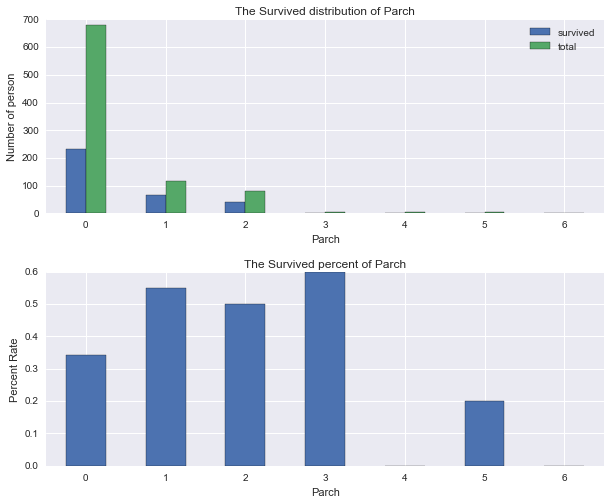

In [233]:
#titanic_data_c['Parch'].plot.hist()
survived_by_field(titanic_data, 'Parch')

从上表可看出有Parch 的生存率高于平均生存率, 新建Family列，对Parch进行分类

        survived  total  Survived
Family                           
False        233    678  0.343658
True         109    213  0.511737


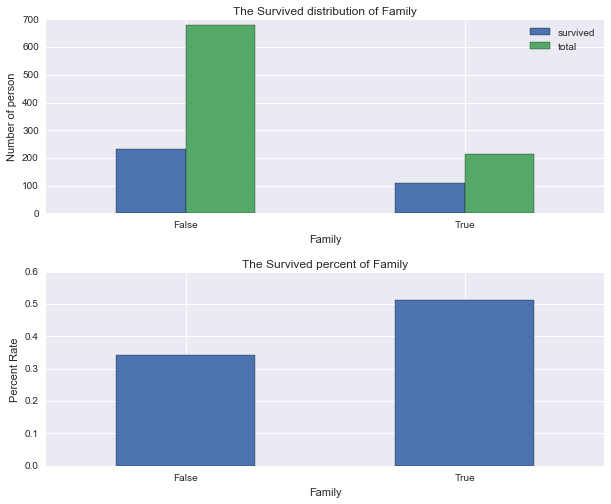

In [234]:
titanic_data_c['Family'] = (titanic_data_c['Parch'] != 0)
survived_by_field(titanic_data_c, 'Family')

将有Parch关系的乘客归类，Parch生存率明显较高为0.51


            survived  total  Survived
Age Group2                           
(0, 6]            32     46  0.695652
(6, 18]           18     43  0.418605
(18, 30]          21     37  0.567568
(30, 60]          33     64  0.515625
(60, 90]           0      3  0.000000


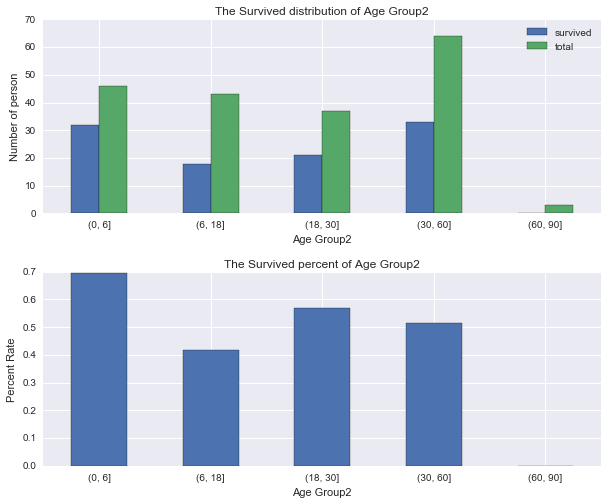

In [236]:
#对Parch类乘客进行年龄段划分，查看生存率差异
titanic_data_c['Age Group2'] = pd.cut(titanic_data_c['Age'], bins=[0,6,18,30,60,90])
survived_by_field(titanic_data_c[titanic_data_c['Family']], 'Age Group2')

结论：
- 在有Parch关系的乘客中，0-60岁的生存率都高于平均生存率0.38，最高的是0-6岁群体，这应该是小孩更易得到照顾。
- 6-18岁群体，生存率较低0.42，不清楚原因
- 从数据上低年龄乘客和成年乘客的生存率都高于平均值，难以判断是否有父母把生存机会让给孩子的情况出现，如果有家庭数据可能能够进一步分析，从名字关系分析也许是个思路。

## 3.6 Sibsp 关系下生存率分析

建立‘Related’列，值为True 表示有伴侣或兄妹 

         survived  total  Survived
Related                           
False         210    608  0.345395
True          132    283  0.466431


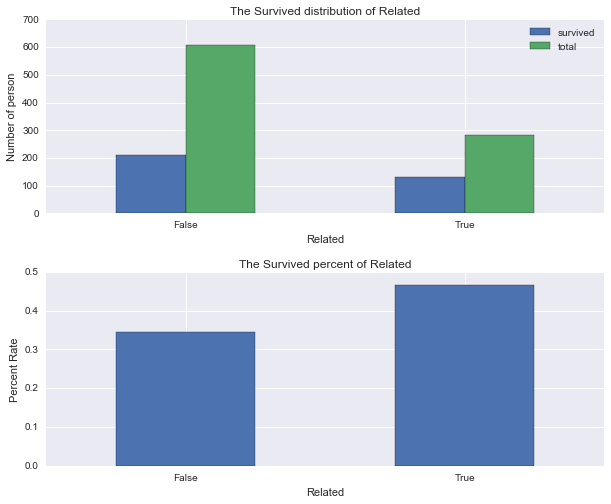

In [239]:
# titanic_data_c['SibSp'].plot.hist()
titanic_data_c['Related'] = (titanic_data_c['SibSp'] != 0)
survived_by_field(titanic_data_c, 'Related')

Related 为 True 时，生存率为0.46，稍高于平均值0.38

In [240]:
titanic_data_c.corr(method='pearson', min_periods=1)['Survived']

PassengerId   -0.005007
Survived       1.000000
Pclass        -0.338481
Age           -0.077221
SibSp         -0.035322
Parch          0.081629
Fare           0.257307
AgeNew        -0.078816
Sex1          -0.543351
Family         0.147408
Related        0.115867
Name: Survived, dtype: float64

从相关系数看对生存率影响Sibsp小于亲子关

        survived  total  Survived
Sex                              
female        96    140  0.685714
male          36    143  0.251748


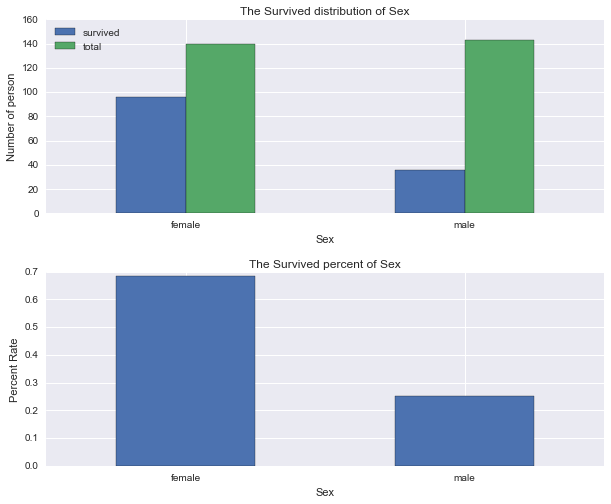

In [238]:
survived_by_field(titanic_data_c[titanic_data_c['Related']], 'Sex')

性别之间差异与乘客总体样本之间没有明显差异

# 结论
- 仓位等级、性别、年龄对与生存都有较强相关性，从相关系数看性别影响最大(年龄分段未包含在相关系数计算中）。而0-6岁群体是所有乘客中生存率最高的。
- 有亲子关系样本的生存率要高于整体，因为缺乏家庭分组关系没有分析出是否有父母让出生存机会给孩子的情况。
- 有兄妹/伴侣关系的乘客群体生存率略高于整体，这个群体内部性别与生存率关系与整体样本保持一致。
- 数据中年龄缺失177个，对与年龄相关分析有较大影响
- Fare 数据有较大异常，未找到原因，分析时略过了。
- 总乘客2224名，样本891名，超过1/3, 采样方式未知，并不能完全反应整体情况(但具有一定代表性）
- 上述分析只是表明不同参数之间的相关性，并不意味着有因果关系，相互关系也许有潜在变量影响，比如船舱的位置、发生船难时乘客所在的区域等。